In [1]:
# Package Setup
import Pkg;
# Pkg.update()

# Julia Packages
using Distributions
using LinearAlgebra
using Statistics
using PGFPlots

# Satellite Dynamics Packages
using SatelliteDynamics

# Load SatelliteTasking - Reclone to keep version current
Pkg.clone("..") # For some reason this doens't work with Pkg.add + PackageSpec. Why?
using SatelliteTasking
using SatelliteTasking.SatellitePlanning
using SatelliteTasking.Analysis

# Temporary for now
Pkg.add("JuMP")
Pkg.add("Gurobi")
using JuMP
using Gurobi

┌ Warning: Pkg.clone is only kept for legacy CI script reasons, please use `add`
└ @ Pkg.API /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Pkg/src/API.jl:386


 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


┌ Info: Recompiling stale cache file /Users/deddy/.julia/compiled/v1.1/SatelliteTasking/HFrko.ji for SatelliteTasking [30f2e302-0ae1-11e9-1cda-0f4324764595]
└ @ Base loading.jl:1184


  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 % Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


In [2]:
# Configure simulation
epc0 = Epoch(2019, 1, 1, 0, 0, 0, tsys=:UTC) # Start of time span
epcf = Epoch(2019, 1, 2, 0, 0, 0, tsys=:UTC) # End of simulation time span

# Set Simulation Time Step
timestep = 1
dtmax    = 5

# Define Satellite Orbit
oe   = [R_EARTH + 500e3, 0, 90.0, 0, 0, 0]
eci0 = sOSCtoCART(oe, use_degrees=true)

# Numer of perturbed orbits to simulate
num_orbits = 1

# Set Perturbation Values 
pos_error = 5000 # Position knowledge error [m]
vel_error = 5    # Velocity knowledge error [m/s]
orb_mean  = zeros(Float64, 6)
orb_sdev  = vcat((pos_error/sqrt(3)*ones(Float64, 3))..., (vel_error/sqrt(3)*ones(Float64, 3))...)

# Simulate true and perturbed orbits
@time true_orbit, perturbed_orbits, eci_errors = simulate_orbits(num_orbits, epc0, epcf, eci0, orb_mean, orb_sdev, timestep=timestep, dtmax=dtmax);

Simulating perturbed orbit 1
Simulating perturbed orbit 2
Simulating perturbed orbit 3
Simulating perturbed orbit 4
Simulating perturbed orbit 5
Simulating perturbed orbit 6
Simulating perturbed orbit 7
Simulating perturbed orbit 8
Simulating perturbed orbit 9
Simulating perturbed orbit 10
 99.321252 seconds (996.39 M allocations: 42.460 GiB, 9.96% gc time)


In [3]:
# Compute True and perturbed collects

# Load test images
# @time images = load_images("../data/landsat_test.json", dwell_time=5.0);
# @time images = load_images("../data/landsat_test_150.json", dwell_time=5.0);
# @time images = load_images("../data/landsat_test_300.json", dwell_time=5.0);
@time images = load_images("../data/landsat_test_600.json", dwell_time=5.0);
num_images = length(images)

# Compute true and perturbed opportunities
@time true_opportunities, perturbed_opportunities, mean_diff, sdev_diff, missing_opportunities = compute_perturbed_opportunities(true_orbit, perturbed_orbits, images, epc_step=3600);

# 
@time collects = compute_collects_by_number(true_opportunities, 10);

# Compute feasible collects
image_collects = group_image_collects(collects) # Group collects by image
num_feasible   = 0
for img in keys(image_collects)
    if length(image_collects[img]) > 0
        num_feasible += 1
    end
end
pct_feasible = num_feasible/num_images*100

println("$num_feasible out of $num_images images have collection opportunities.")

  0.279172 seconds (697.21 k allocations: 36.811 MiB, 3.30% gc time)
Computing opportunities for perturbed orbit: 1
Computing opportunities for perturbed orbit: 2
Computing opportunities for perturbed orbit: 3
Computing opportunities for perturbed orbit: 4
Computing opportunities for perturbed orbit: 5
Computing opportunities for perturbed orbit: 6
Computing opportunities for perturbed orbit: 7
Computing opportunities for perturbed orbit: 8
Computing opportunities for perturbed orbit: 9
Computing opportunities for perturbed orbit: 10
563.969926 seconds (7.42 G allocations: 782.687 GiB, 16.24% gc time)
  0.194197 seconds (504.35 k allocations: 25.205 MiB, 3.55% gc time)
552 out of 600 images have collection opportunities.


In [4]:
println(sdev_diff[1, :])
println(sdev_diff[2, :])
println(sdev_diff[3, :])
println(missing_opportunities)

[1.57235, 6.62455, 14.1883, 18.0854, 24.6135, 32.5594, 36.292, 43.5378, 46.5372, 54.5067, 61.4904, 64.7324, 72.1979, 79.0095, 84.1979, 90.0392, 91.6267, 108.515, 108.285, 111.382, 115.804, 127.198, 130.481, 133.135]
[4.07121, 10.8489, 18.94, 23.8201, 29.2863, 37.8668, 40.2856, 47.8108, 51.0972, 57.8384, 66.0887, 68.6987, 76.0036, 83.0881, 85.8139, 94.4741, 95.259, 114.05, 112.495, 115.827, 119.629, 130.634, 135.013, 135.285]
[5.09444, 5.27377, 5.66949, 7.12469, 6.06201, 6.74745, 5.03693, 5.47833, 6.95412, 5.51706, 6.30561, 6.96338, 6.44854, 5.1601, 5.63456, 7.86057, 5.30036, 9.61124, 6.61194, 8.98158, 7.7971, 9.02428, 12.6846, 17.7381]
[1, 6, 2, 5, 0, 9, 3, 7, 4, 9, 7, 17, 10, 13, 5, 3, 11, 2, 3, 5, 33, 7, 16, 21]


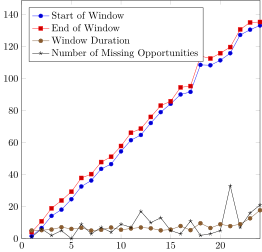

In [5]:
# Plot Differences in Opportunities
Axis([
    Plots.Linear(1:24, sdev_diff[1, :], legendentry="Start of Window")
    Plots.Linear(1:24, sdev_diff[2, :], legendentry="End of Window")
    Plots.Linear(1:24, sdev_diff[3, :], legendentry="Window Duration")
    Plots.Linear(1:24, missing_opportunities, legendentry="Number of Missing Opportunities")
], width="10cm", height="10cm", legendPos="north west", xmin=0, xmax=24, ymin=0)

In [6]:
# Graph planning
@time path, reward, image_list = sp_graph_policy(collects, Function[constraint_agility_single_axis], horizon=0.0, allow_repeats=false)
graph_path, graph_reward, graph_image_list = path, reward, image_list

println("Total planning reward: $reward")
println("Number of images collected: $(length(image_list))/$num_images, $(length(image_list)/num_images*100)")
println("Number of feasible images collected: $(length(image_list))/$num_feasible, $(length(image_list)/num_feasible*100)")

167.985333 seconds (966.00 M allocations: 44.419 GiB, 43.04% gc time)
Total planning reward: 546.0
Number of images collected: 546/600, 91.0
Number of feasible images collected: 546/552, 98.91304347826086


In [7]:
# MILP planning
@time path, reward, image_list = sp_milp_policy(collects, Function[constraint_agility_single_axis], horizon=0.0, allow_repeats=false)
milp_path, milp_reward, milp_image_list = path, reward, image_list

println("Total planning reward: $reward")
println("Number of images collected: $(length(image_list))/$num_images, $(length(image_list)/num_images*100)")
println("Number of feasible images collected: $(length(image_list))/$num_feasible, $(length(image_list)/num_feasible*100)")

Academic license - for non-commercial use only
Optimize a model with 782976 rows, 18322 columns and 1583170 nonzeros
Variable types: 0 continuous, 18322 integer (18322 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Variable types: 0 continuous, 18322 integer (18322 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.08s

Solved with dual simplex

Root relaxation: objective 5.520000e+02, 548 iterations, 0.71 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                     552.0000000 18322.0000  3219%     -    1s
     0     0          -    0       552.00000  552.00000  0.00%     -    2s

Explored 0 nodes (1268 simplex iterations) in 2.22 seconds
Thread count was 12 (of 12 

In [8]:
# MDP Planning

# Test MDP Forward Search Solution
@time begin
cp = compute_collect_probability(collects, perturbed_opportunities);
path, reward, image_list = mdp_forward_search(collects, Function[constraint_agility_single_axis], 
                                                    images, cp,
                                                    horizon=7200, gamma=0.7, search_depth=1);
end

mdp_path, mdp_reward, mdp_image_list = path, reward, image_list

println("Total planning reward: $reward")
println("Number of images collected: $(length(image_list))/$num_images, $(length(image_list)/num_images*100)")
println("Number of feasible images collected: $(length(image_list))/$num_feasible, $(length(image_list)/num_feasible*100)")

MethodError: MethodError: no method matching isless(::Collect, ::Epoch)
Closest candidates are:
  isless(!Matched::Missing, ::Any) at missing.jl:70
  isless(!Matched::Epoch, ::Epoch) at /Users/deddy/.julia/packages/SatelliteDynamics/Bd0Ot/src/time.jl:598
  isless(!Matched::Union{CategoricalString{R}, CategoricalValue{T,R} where T} where R, ::Any) at /Users/deddy/.julia/packages/CategoricalArrays/ucKV2/src/value.jl:179
  ...

In [9]:
# Plan Evaluation

function sp_check_feasibility(collects::Array{<:Any,1}, constraint_list::Array{Function,1})
    # Independently check that all constraints are still met
    for i in 1:length(collects)-1
        col_start = collects[i]
        col_end   = collects[i+1]

        # Set transition valid by default
        valid_transition = true

        for constraint in constraint_list
            # Use logical and to evaulate path feasibility on graph
            valid_transition = valid_transition && constraint(col_start, col_end)
        end

        if !valid_transition
            println("Collect Failed:\n Start: $col_start\n End: $col_end\n")
            return false
        end
    end
    
    return true
end

graph_feasible = sp_check_feasibility(reverse(graph_path), Function[constraint_agility_single_axis])
println("GRAPH Constraint Check: $(graph_feasible ? "PASS" : "FAIL")")
milp_feasible = sp_check_feasibility(milp_path, Function[constraint_agility_single_axis])
println("MILP Constraint Check: $(milp_feasible ? "PASS" : "FAIL")")
mdp_feasible = sp_check_feasibility(path, Function[constraint_agility_single_axis])
println("MDP Constraint Check: $(mdp_feasible ? "PASS" : "FAIL")")

Collect Failed:
 Start: Collect(Ptr: 5085918512, Orbit: 0, Image: 4635710640, Opportunity: 4618240256, Start: Epoch(2019-01-01T22:41:16.000Z), End: Epoch(2019-01-01T22:41:21.000Z))
 End: Collect(Ptr: 5085890528, Orbit: 0, Image: 4633033264, Opportunity: 4594016640, Start: Epoch(2019-01-01T22:19:05.000Z), End: Epoch(2019-01-01T22:19:10.000Z))

GRAPH Constraint Check: FAIL
MILP Constraint Check: PASS
MDP Constraint Check: PASS


In [10]:
# function c_graph(collects::Array{Collect, 1}, constraint_list::Array{Function, 1}; horizon=0::Real)
    
#     # Sort Collects to ensure they are in time-asecnding order
#     sort!(collects, by = x -> x.sow)

#     # Initialize validate transition graph
#     graph = Dict{Collect, Array{Collect, 1}}()

#     for start_collect in collects
#         # List of valid edges/transitions for start_collect
#         graph[start_collect] = Array{Collect, 1}[]
        
#         for end_collect in collects
#             # Decide to insert edge
#             if (start_collect       == end_collect || 
#                 start_collect.image == end_collect.image ||
#                 end_collect.sow < start_collect.eow)
#                 # Skip insertion if same collect, image, or starts before the current
#                 # collection ends (no instantaneous manevers)
#                 continue
#             elseif horizon > 0.0 && end_collect.sow > (start_collect.eow + horizon)
#                 # Since we know collects are sorted we can break building the
#                 # transition grarph if the distance from the next to the next start
#                 # is greater than the look-ahead horizon
#                 break
#             else
#                 # Set transition valid by default
#                 valid_transition = true

#                 for constraint in constraint_list
#                     # If not valid transition break early
#                     if valid_transition == false
#                         continue
#                     end

#                     # Use logical and to evaulate path feasibility on graph
#                     valid_transition = valid_transition && constraint(start_collect, end_collect)
#                 end

#                 if valid_transition
#                     push!(graph[start_collect], end_collect)
#                 end
#             end
#         end
#     end
    
#     return graph
# end

@time t_graph = sp_construct_graph(collects, Function[constraint_agility_single_axis])

 78.388587 seconds (613.54 M allocations: 22.606 GiB, 23.18% gc time)


Dict{Collect,Array{Collect,1}} with 18322 entries:
  Collect(Ptr: 5085487008,… => Collect[Collect(Ptr: 5085484608, Orbit: 0, Image…
  Collect(Ptr: 5076971568,… => Collect[Collect(Ptr: 5077048448, Orbit: 0, Image…
  Collect(Ptr: 5085114496,… => Collect[Collect(Ptr: 5085114896, Orbit: 0, Image…
  Collect(Ptr: 5084973344,… => Collect[Collect(Ptr: 5084978384, Orbit: 0, Image…
  Collect(Ptr: 5077285824,… => Collect[Collect(Ptr: 5077286144, Orbit: 0, Image…
  Collect(Ptr: 5069939712,… => Collect[Collect(Ptr: 5069940112, Orbit: 0, Image…
  Collect(Ptr: 5085611200,… => Collect[Collect(Ptr: 5085618400, Orbit: 0, Image…
  Collect(Ptr: 5075995712,… => Collect[Collect(Ptr: 5075993152, Orbit: 0, Image…
  Collect(Ptr: 5079661664,… => Collect[Collect(Ptr: 5079662224, Orbit: 0, Image…
  Collect(Ptr: 5085630544,… => Collect[Collect(Ptr: 5085629744, Orbit: 0, Image…
  Collect(Ptr: 5085652848,… => Collect[Collect(Ptr: 5085657728, Orbit: 0, Image…
  Collect(Ptr: 5095203680,… => Collect[]
  Collect(Ptr: 50

In [ ]:
for k in keys(t_graph)
    for col in t_graph[k]
        if !constraint_agility_single_axis(k, col)
            println("Invalid transition in constructed graph:\n Start: $k\n End: $col\n")
        end
    end
end

println("All tranitions valid...")

In [ ]:
for i in 1:length(mdp_path)-1
        col_start = mdp_path[i]
        col_end   = mdp_path[i+1]

        # Set transition valid by default
        valid_transition = true

        for constraint in [constraint_agility_single_axis]
            # Use logical and to evaulate path feasibility on graph
            valid_transition = valid_transition && constraint(col_start, col_end)
        end

        if !valid_transition
            println("$i - Collect Failed:\n Start: $col_start\n End: $col_end\n")
#             return false
        end
    end

In [ ]:
println(mdp_path[20])
println(mdp_path[21])
constraint_agility_single_axis(mdp_path[20], mdp_path[21])